In [1]:
text = 'You say goodbye and I say hello.'

In [2]:
RE_SEG = re.compile('(\w+)', re.U)


def preprocess(sent):
    return sent.lower()


# def word_seg(sent):
#     return [w for w in RE_SEG.split(sent) if w.strip()]


def word_seg(sent):
    sent = sent.replace('.', ' .')
    return sent.split(' ')


def transform_words(words):
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word in word_to_id:
            continue

        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
    
    # 使用 id，将原始文本转换为 array
    corpus = [word_to_id[w] for w in words]
    corpus = np.array(corpus)
    return corpus, word_to_id, id_to_word


def transform(raw_text):
    sent = preprocess(raw_text)
    words = word_seg(sent)
    return transform_words(words)

In [3]:
corpus, word_to_id, id_to_word = transform(text)
print(corpus)

word_to_id, id_to_word

[0 1 2 3 4 1 5 6]


({'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [4]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for word_i, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_i = word_i - i
            right_i = word_i + i
            if left_i >= 0:
                left_word_id = corpus[left_i]
                co_matrix[word_id, left_word_id] += 1
            if right_i < corpus_size:
                right_word_id = corpus[right_i]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

In [5]:
co_matrix = create_co_matrix(corpus, len(id_to_word))
co_matrix

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [8]:
def cos_similarity(x, y, eps=1e-8):
    # 添加一个极小值，防止出现除以零错误
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [9]:
c1 = co_matrix[word_to_id['you']]
c2 = co_matrix[word_to_id['i']]
cos_similarity(c1, c2)

0.7071067758832467

In [17]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        # new word, no sims
        print(f'{query} is unknown')
        return []
    
    word_id = word_to_id[query]
    word_vec = word_matrix[word_id]
    
    vocab_size = len(id_to_word)
    sims = np.zeros(vocab_size)
    for i in range(vocab_size):
        sims[i] = cos_similarity(word_vec, word_matrix[i])
    
    result = []
    for i in (-sims).argsort():
        if id_to_word[i] == query:
            continue
        result.append((id_to_word[i], sims[i]))
        
        if len(result) >= top:
            break
    return result

In [18]:
for word in most_similar('you', word_to_id, id_to_word, co_matrix):
    print(word)

('goodbye', 0.7071067758832467)
('i', 0.7071067758832467)
('hello', 0.7071067758832467)
('say', 0.0)
('and', 0.0)


In [29]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    # 每个词重复计算一次
    N = np.sum(C)
    S = np.sum(C, axis=0)
    
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[i] * S[j]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print(f'{100*cnt/total}% done')
                    
    return M

In [31]:
W = ppmi(co_matrix)

In [32]:
np.set_printoptions(precision=3)
print('PPMI')
W

PPMI


array([[0.   , 1.807, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [1.807, 0.   , 0.807, 0.   , 0.807, 0.807, 0.   ],
       [0.   , 0.807, 0.   , 1.807, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.807, 0.   , 1.807, 0.   , 0.   ],
       [0.   , 0.807, 0.   , 1.807, 0.   , 0.   , 0.   ],
       [0.   , 0.807, 0.   , 0.   , 0.   , 0.   , 2.807],
       [0.   , 0.   , 0.   , 0.   , 0.   , 2.807, 0.   ]], dtype=float32)

In [33]:
U, S, V = np.linalg.svd(W)

In [35]:
co_matrix[0], W[0], U[0]

(array([0, 1, 0, 0, 0, 0, 0], dtype=int32),
 array([0.   , 1.807, 0.   , 0.   , 0.   , 0.   , 0.   ], dtype=float32),
 array([ 3.409e-01,  0.000e+00, -1.205e-01, -3.886e-16, -9.323e-01,
        -1.110e-16, -2.426e-17], dtype=float32))

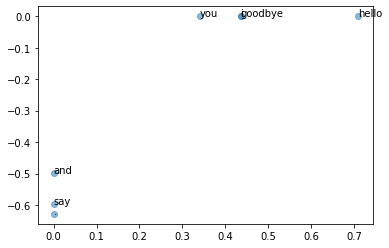

In [36]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

# PTB Corpus

In [41]:
import sys
sys.path.insert(0, '..')
from dataset import ptb

In [43]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

In [46]:
print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()

print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()

print('word_to_id[car]:', word_to_id['car'])
print('word_to_id[happy]:', word_to_id['happy'])
print('word_to_id[lexus]:', word_to_id['lexus'])

corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id[car]: 3856
word_to_id[happy]: 4428
word_to_id[lexus]: 7426


In [47]:
# 计算 svd
window_size = 2
wordvec_size = 100

vocab_size = len(word_to_id)
print('counting co-matrix')
C = create_co_matrix(corpus, vocab_size, window_size=window_size)
len(C)

counting co-matrix


10000

In [48]:
print('calculating PPMI...')
W = ppmi(C, verbose=True)
print(len(W))

calculating PPMI...
1.000001% done
2.000002% done
3.000003% done
4.000004% done
5.000005% done
6.000006% done
7.000007% done
8.000008% done
9.000009% done
10.00001% done
11.000011% done
12.000012% done
13.000013% done
14.000014% done
15.000015% done
16.000016% done
17.000017% done
18.000018% done
19.000019% done
20.00002% done
21.000021% done
22.000022% done
23.000023% done
24.000024% done
25.000025% done
26.000026% done
27.000027% done
28.000028% done
29.000029% done
30.00003% done
31.000031% done
32.000032% done
33.000033% done
34.000034% done
35.000035% done
36.000036% done
37.000037% done
38.000038% done
39.000039% done
40.00004% done
41.000041% done
42.000042% done
43.000043% done
44.000044% done
45.000045% done
46.000046% done
47.000047% done
48.000048% done
49.000049% done
50.00005% done
51.000051% done
52.000052% done
53.000053% done
54.000054% done
55.000055% done
56.000056% done
57.000057% done
58.000058% done
59.000059% done
60.00006% done
61.000061% done
62.000062% done
63.

In [49]:
print('calculating SVD ...')
try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    print('use normal linalg ...')
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]
word_vecs.shape

calculating SVD ...


(10000, 100)

In [52]:
queries = ['you', 'year', 'car', 'toyota']
for query in queries:
    print('similar to', query)
    for word in most_similar(query, word_to_id, id_to_word, word_vecs, top=5):
        print(word)

similar to you
('i', 0.6898401379585266)
('we', 0.6181826591491699)
('do', 0.5525362491607666)
('anybody', 0.5482551455497742)
("'ll", 0.5085446834564209)
similar to year
('month', 0.7086570858955383)
('quarter', 0.6261984705924988)
('earlier', 0.5967453122138977)
('fiscal', 0.596717357635498)
('last', 0.5863330960273743)
similar to car
('auto', 0.6358515024185181)
('vehicle', 0.5932095646858215)
('truck', 0.5302572846412659)
('cars', 0.513241171836853)
('luxury', 0.501797080039978)
similar to toyota
('motor', 0.7365849614143372)
('motors', 0.7265141010284424)
('lexus', 0.6589174270629883)
('nissan', 0.6569986939430237)
('honda', 0.5916574001312256)
